## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Michael Pyrcz, Carlos Torres-Verdin, 2024
***

In [1]:
import numpy as np
import pandas as pd

import lasio
from scipy import linalg, optimize
import matplotlib.pyplot as plt

In [2]:
def plot_curve(ax, df, curve, lb=None, ub=None, color='k', pad=0, s=2, mult=1,
               units:str=None, mask=None, offset:int=0, title:str=None, label:str=None,
               semilog:bool=False, bar:bool=False, fill:bool=None, rightfill:bool=False,
               marker=None, edgecolor=None, ls=None, alpha=None):
        if mask is None:
            x, y = -offset+mult*df[curve], df.index
        else:
            x, y = -offset+mult*df[curve][mask], df.index[mask]
        lb = x[~np.isnan(x)].min() if lb is None else lb
        ub = x[~np.isnan(x)].max() if ub is None else ub
        if semilog:
            ax.semilogx(x, y, c=color, label=curve, alpha=alpha,
                        marker=marker, markersize=s, markeredgecolor=edgecolor, linestyle=ls, linewidth=s)
        else:
            if bar:
                ax.barh(y, x, color=color, label=curve, alpha=alpha)
            else:
                ax.plot(x, y, c=color, label=curve, alpha=alpha,
                        marker=marker, markersize=s, markeredgecolor=edgecolor, linewidth=s, linestyle=ls)
        if fill:
            ax.fill_betweenx(y, x, ub, alpha=alpha, color=color) if rightfill else ax.fill_betweenx(y, lb, x, alpha=alpha, color=color)
        if units is None:
            if hasattr(df, 'curvesdict'):
                units = df.curvesdict[curve].unit
            else:
                units = ''
        ax.set_xlim(lb, ub)
        ax.grid(True, which='both')
        ax.set_title(title, weight='bold') if title != None else None
        xlab = label if label is not None else curve
        if offset != 0:
            ax.set_xlabel('{} [{}] with {} offset'.format(xlab, units, offset), color=color, weight='bold')
        else:
            ax.set_xlabel('{} [{}]'.format(xlab, units), color=color, weight='bold')
        ax.xaxis.set_label_position('top'); ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_tick_params(color=color, width=s)
        ax.spines['top'].set_position(('axes', 1+pad/100))
        ax.spines['top'].set_edgecolor(color); ax.spines['top'].set_linewidth(2)
        if ls is not None:
            ax.spines['top'].set_linestyle(ls)
        return None

In [3]:
column_names = ['AT10','AT30','AT60','AT90','GR','Rv','Rh']
index_name   = 'DEPTH'

In [4]:
well1 = lasio.read('well1.las').df()
case1 = well1[['AT10','AT30','AT60','AT90','GR','RV72H_1D', 'RH72H_1D']].dropna()
case1.columns = column_names
case1.index.name = index_name

In [5]:
well2 = lasio.read('well2.LAS').df()
case2 = well2[['AT10','AT30','AT60','AT90','HCGR','RV72_1DF','RH72_1DF']].dropna()
case2.columns = column_names
case2.index.name = index_name

In [45]:
def resistivity_inversion(df, Rvsh=None, Rhsh=None, lambda_reg=1e-4, Wd_matrix:bool=False,
                          x0=[0.5, 1.5], method='L-BFGS-B', tol=1e-4, maxiter=500):
    if Rvsh is None:
        Rvsh = df['Rv'].iloc[np.argmax(df['GR'])]
    if Rhsh is None:
        Rhsh = df['Rh'].iloc[np.argmax(df['GR'])]

    df['Csh_lin'] = (df['GR'] - df['GR'].min()) / (df['GR'].max() - df['GR'].min())

    def objective(variables, *args):
        Csh, Rs = variables
        Rv,  Rh = args[0], args[1]
        eq1 = (Csh*Rvsh + (1-Csh)*Rs) - Rv
        eq2 = (Csh/Rhsh + (1-Csh)/Rs) - (1/Rh)
        eqs = [eq1/Rv, eq2*Rh] if Wd_matrix else [eq1, eq2]
        return linalg.norm(eqs) + lambda_reg*linalg.norm(variables)
    
    def inversion():
        res_aniso = df[['Rv','Rh']]
        sol, fun, jac, nfev = [], [], [], []
        for _, row in res_aniso.iterrows():
            Rv_value, Rh_value = row['Rv'], row['Rh']
            solution = optimize.minimize(objective,
                                         x0      = x0,
                                         args    = (Rv_value, Rh_value),
                                         bounds  = [(0,1), (None,None)],
                                         method  = method,
                                         tol     = tol,
                                         options = {'maxiter':maxiter})
            fun.append(solution.fun); jac.append(solution.jac); nfev.append(solution.nfev)
            jac1, jac2 = np.array(jac)[:,0], np.array(jac)[:,1]
            sol.append({'Rv':Rv_value, 'Rh':Rh_value, 'Csh':solution.x[0], 'Rs':solution.x[1]})
        sol = pd.DataFrame(sol, index=res_aniso.index)
        sol['fun'], sol['nfev'], sol['jac1'], sol['jac2'], sol['norm_jac'] = fun, nfev, jac1, jac2, linalg.norm(jac, axis=1)
        return sol
    
    def simulate(sol):
        Csh, Rs = sol['Csh'], sol['Rs']
        Rv_sim = Csh*Rvsh + (1-Csh)*Rs
        Rh_sim = Csh/Rhsh + (1-Csh)/Rs
        sim = pd.DataFrame({'Rv_sim':Rv_sim, 'Rh_sim':1/Rh_sim}, index=sol.index)
        return sim
    
    def error(sol, sim):
        Rv_true, Rh_true = sol['Rv'], sol['Rh']
        Rv_pred, Rh_pred = sim['Rv_sim'], sim['Rh_sim']
        Rv_err = np.abs((Rv_pred - Rv_true) / Rv_true) * 100
        Rh_err = np.abs((Rh_pred - Rh_true) / Rh_true) * 100
        res = pd.DataFrame({'Rv_err':Rv_err, 'Rh_err':Rh_err}, index=sol.index)
        return res
    
    val = df[['AT10','AT30','AT60','AT90','GR','Csh_lin']]
    sol = inversion()
    sim = simulate(sol)
    err = error(sol, sim)
    res_inv = val.join(sol).join(sim).join(err)
    return res_inv

In [69]:
case1_inv = resistivity_inversion(case1, Wd_matrix=True)
case1_inv

,AT10,AT30,AT60,AT90,GR,Csh_lin,Rv,Rh,Csh,Rs,fun,nfev,jac1,jac2,norm_jac,Rv_sim,Rh_sim,Rv_err,Rh_err
DEPTH,,,,,,,,,,,,,,,,,,,
9650.00,1.0775,0.8261,0.7674,0.7382,103.6210,0.962199,0.7833,0.7833,1.000000,0.853510,0.000131,6,-0.121582,0.000065,0.121582,0.783300,0.783300,0.000000,0.000000
9650.25,1.0791,0.8266,0.7685,0.7406,105.2029,0.981099,0.7833,0.7833,1.000000,0.853510,0.000131,6,-0.121582,0.000065,0.121582,0.783300,0.783300,0.000000,0.000000
9650.50,1.0807,0.8271,0.7695,0.7429,106.7848,1.000000,0.7833,0.7833,1.000000,0.853510,0.000131,6,-0.121582,0.000065,0.121582,0.783300,0.783300,0.000000,0.000000
9650.75,1.0823,0.8270,0.7668,0.7438,105.9264,0.989744,0.7833,0.7833,1.000000,0.853510,0.000131,6,-0.121582,0.000065,0.121582,0.783300,0.783300,0.000000,0.000000
9651.00,1.0840,0.8268,0.7641,0.7448,105.0679,0.979486,0.7833,0.7833,1.000000,0.853510,0.000131,6,-0.121582,0.000065,0.121582,0.783300,0.783300,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10248.50,0.9547,0.7695,0.7260,0.7119,94.9540,0.858644,2.9869,0.6525,0.982779,127.813815,0.194104,150,0.432758,-0.000070,0.432758,2.970851,0.796940,0.537307,22.136358
10248.75,0.9513,0.7688,0.7275,0.7134,95.6692,0.867190,3.5105,0.6583,0.981352,145.772855,0.189874,129,0.733994,-0.000101,0.733994,3.487119,0.798103,0.666032,21.237028
10249.00,0.9480,0.7681,0.7291,0.7149,96.3843,0.875734,4.0340,0.6642,0.973157,121.123239,0.186849,108,0.021108,-0.000091,0.021108,4.013604,0.804763,0.505615,21.162702


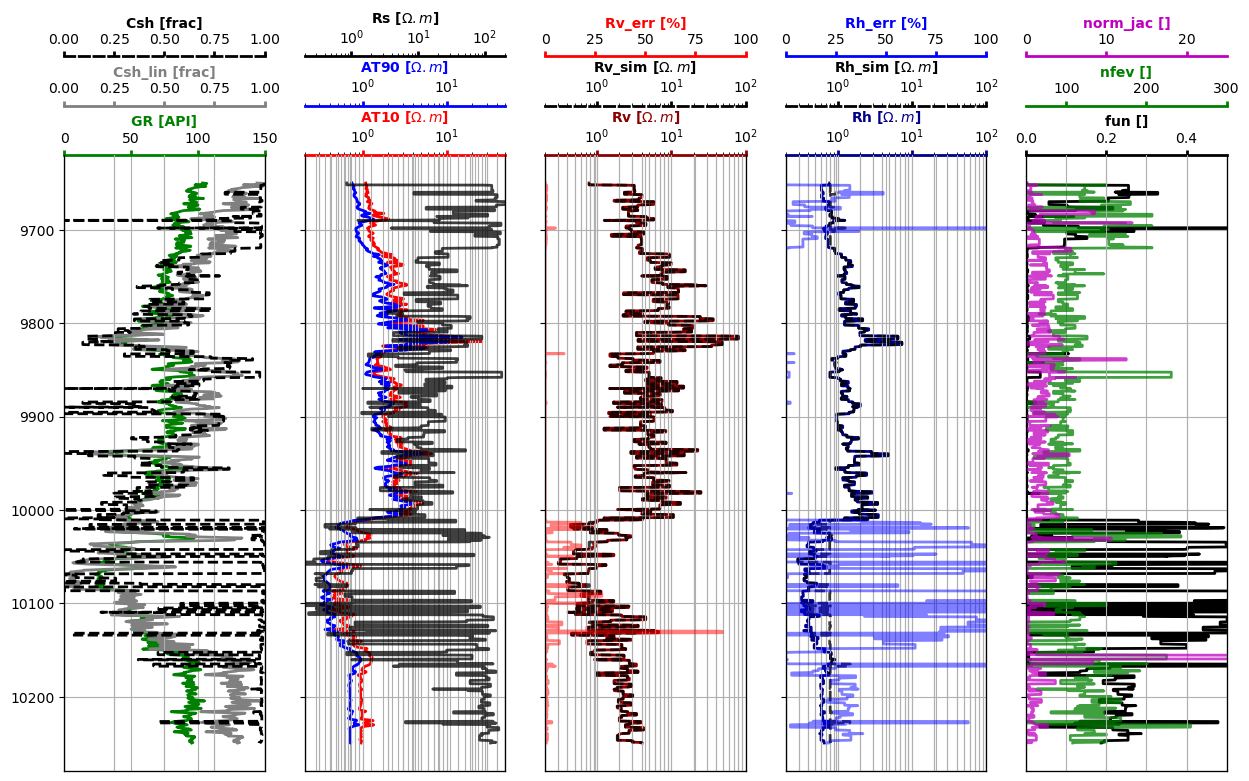

In [72]:
fig, axs = plt.subplots(1, 5, figsize=(15,8), sharey=True)
ax1, ax2, ax3, ax4, ax5 = axs

ax11, ax12 = ax1.twiny(), ax1.twiny()
plot_curve(ax1,  case1_inv, 'GR',      lb=0, ub=150, color='g',    units='API',  pad=0)
plot_curve(ax11, case1_inv, 'Csh_lin', lb=0, ub=1,   color='gray', units='frac', pad=8)
plot_curve(ax12, case1_inv, 'Csh',     lb=0, ub=1,   color='k',    units='frac', ls='--', pad=16)

ax21, ax22 = ax2.twiny(), ax2.twiny()
plot_curve(ax2,  case1_inv, 'AT10', lb=0.2, ub=50, color='r', units='$\Omega.m$', semilog=True, pad=0)
plot_curve(ax21, case1_inv, 'AT90', lb=0.2, ub=50, color='b', units='$\Omega.m$', semilog=True, pad=8)
plot_curve(ax22, case1_inv, 'Rs',   lb=0.2, ub=200, color='k', units='$\Omega.m$', alpha=0.75, semilog=True, pad=16)

ax31, ax32 = ax3.twiny(), ax3.twiny()
plot_curve(ax3,  case1_inv, 'Rv',     lb=0.2, ub=100, color='darkred',  units='$\Omega.m$',   semilog=True, pad=0)
plot_curve(ax31, case1_inv, 'Rv_sim', lb=0.2, ub=100, color='k', units='$\Omega.m$', ls='--', alpha=0.75, semilog=True, pad=8)
plot_curve(ax32,  case1_inv, 'Rv_err', lb=1e-9, ub=100, color='red', units='%', alpha=0.5, pad=16)

ax41, ax42 = ax4.twiny(), ax4.twiny()
plot_curve(ax4,  case1_inv, 'Rh',     lb=0.2, ub=100, color='darkblue',  units='$\Omega.m$',  semilog=True, pad=0)
plot_curve(ax41, case1_inv, 'Rh_sim', lb=0.2, ub=100, color='k', units='$\Omega.m$', alpha=0.75, ls='--', semilog=True, pad=8)
plot_curve(ax42, case1_inv, 'Rh_err', lb=1e-9, ub=100, color='blue', units='%', alpha=0.5, pad=16)

ax51, ax52 = ax5.twiny(), ax5.twiny()
plot_curve(ax5,  case1_inv, 'fun',      lb=0, ub=0.5,  color='k', pad=0)
plot_curve(ax51, case1_inv, 'nfev',     lb=50, ub=300, color='g', alpha=0.75, pad=8)
plot_curve(ax52, case1_inv, 'norm_jac', lb=0, ub=25,  color='m', alpha=0.75, pad=16)

plt.gca().invert_yaxis()
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

In [14]:
class Objective(nn.Module):
    def __init__(self, lambda_reg=1e-4, Wd_matrix:bool=False):
        super(Objective, self).__init__()
        self.Rvsh = nn.Parameter(torch.tensor(1.0))
        self.Rhsh = nn.Parameter(torch.tensor(1.0))
        self.Csh  = nn.Parameter(torch.tensor(0.5))
        self.Rs   = nn.Parameter(torch.tensor(1.0))
        self.lambda_reg = lambda_reg
        self.Wd_matrix = Wd_matrix

        self.Rv, self.Rh = None, None
        self.Csh_lin = None
        self.fun, self.jac, self.nfev = None, None, None
        self.sol, self.sim, self.err  = None, None, None

        self.loss = None
    
    def forward(self, Rv, Rh):
        self.Rv, self.Rh = Rv, Rh
        self.Csh_lin = (self.GR - self.GR.min()) / (self.GR.max() - self.GR.min())
        eq1 = (self.Csh*self.Rvsh + (1-self.Csh)*self.Rs) - self.Rv
        eq2 = (self.Csh/self.Rhsh + (1-self.Csh)/self.Rs) - (1/self.Rh)
        self.fun = torch.norm(torch.stack([eq1/self.Rv, eq2*self.Rh])) + self.lambda_reg*torch.norm(torch.stack([self.Csh, self.Rs]))
        self.jac = torch.autograd.grad(self.fun, [self.Csh, self.Rs], create_graph=True)
        self.nfev = 1
        self.sol = {'Rv':self.Rv, 'Rh':self.Rh, 'Csh':self.Csh, 'Rs':self.Rs}
        self.sim = {'Rv_sim':self.Csh*self.Rvsh + (1-self.Csh)*self.Rs, 'Rh_sim':1/(self.Csh/self.Rhsh + (1-self.Csh)/self.Rs)}
        self.err = {'Rv_err':torch.abs((self.sim['Rv_sim'] - self.sol['Rv']) / self.sol['Rv']) * 100,
                    'Rh_err':torch.abs((self.sim['Rh_sim'] - self.sol['Rh']) / self.sol['Rh']) * 100}
        self.res = {'Rv':self.Rv, 'Rh':self.Rh, 'Csh':self.Csh_lin, 'Rs':self.Rs,
                    'Rv_sim':self.sim['Rv_sim'], 'Rh_sim':self.sim['Rh_sim'],
                    'Rv_err':self.err['Rv_err'], 'Rh_err':self.err['Rh_err']}
        self.loss = self.fun
        return self.loss + self.lambda_reg*torch.norm(torch.stack([self.Csh, self.Rs]))

TypeError: unsupported operand type(s) for -: 'Tensor' and 'NoneType'

In [10]:
model = Y()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

epoch = 0



Y(
  (f): StraighLine()
)

***
# END